## <프로젝트 유형: Multi-Step LSTM Time Series Forecasting>
* windows개념 이용해서 univariate time series forecasting의 방법으로 해결해보고자 함

In [ ]:
# Runned_by_Colab

# 2. Trials 내용
# ReduceLROnPlateau() factor 0.1, patience 3
# 모델의 2번째 레이어를 NLP 217p bidirectional layer로 변경 <-얘가 핵심인듯?

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Dropout, Bidirectional#,Reshape, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read Data
data_path = '/content/drive/MyDrive/Dacon_Data/[DACON]Bit_Trader/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [ ]:
# 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

# 2차원 DF LSTM으로 학습하기 위해 3차원으로 변환시키기
train_x_array = df2d_to_array3d(train_x_df)   #(1380, 1380, 10)
train_y_array = df2d_to_array3d(train_y_df)   #(1380, 120, 10)
test_x_array = df2d_to_array3d(test_x_df)     #(529, 1380, 10)

In [ ]:
# 모델 구성(op1: many-to-one model, op2: many-to-many model(output 모양 바꾸기, return_sequences = True, Window이동 단위 1에서 output 크기로 변경))
# LSTM에 return_sequence=True가 주어지고 Bidirectional이면서 TimeDistributed() 함수가 사용되면 양방향 many-to-many 유형이 된다.https://m.blog.naver.com/chunjein/221589656211
# TimeDistributed() 함수 사용: 모델 layer에 model.add(TimeDistributed(Dense(1, activation='sigmoid')))추가

def build_model():
    seq_len = 120
    model = Sequential()
    # 첫 번째 layer에서 LSTM()매서드 안의 stateful = True는 오히려 다운 퍼포먼스 될 수 있음
    model.add(LSTM(80, activation='tanh', return_sequences= True, input_shape = [seq_len, 1])) 
    model.add(Bidirectional(LSTM(50, activation='tanh')))
    model.add(Dense(1))  #120개의 open값 입력되어 121번째 open값 '하나' 예측   
    
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
    
    return model

In [ ]:
build_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 80)           26240     
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               52400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 78,741
Trainable params: 78,741
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# LearningRateScheduler(scheduler) 구현

# from tensorflow.keras.callbacks import LearningRateScheduler
# # LearningRateScheduler 함수 생성 (epoch이 5이하면 그대로 lr 유지, 아닐시 lr 조정)
# def scheduler(epoch, learning_rate):
#     if epoch < 5:
#         return learning_rate
#     else:
#         return learning_rate * tf.math.exp(-0.1)
# lr = LearningRateScheduler(scheduler)

In [ ]:
# test_x_array에 대한 Auto_Regressive한 Prediction 및 valid_pred_array에 예측 결과 기록

# 1) test_pred_array{예측값 모아두는 3차원 배열(120*1 2차원 배열 529개)} 만들기
test_pred_array = np.zeros([len(test_x_array), 120, 1])

# 2) early_stoppage & reduceLR 정의: https://www.dacon.io/competitions/official/235709/codeshare/2453?page=1&dtype=recent 참고)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 10, mode = 'auto')
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience= 3, mode = 'auto', mindelta = 0.0001, min_lr=0)

# 3) test_x_array로 시계열 Windows 만들기 -> 데이터셋 구성 -> 모델 학습 ||| 예측 -> test_pred_array에 기록 -> window_3d의 첫번째 값 삭제 -> test_pred_array와 window_3d 병합 -> model.predict()에 넣어 예측 -> ***
ep = 30
bs = 120
# idx에 해당하는 샘플 529개 학습: for loop 529번 돌아감
for idx in tqdm(range(test_x_array.shape[0])):  # 529번
    seq_len = 120
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(test_x_array[idx, :, 1][index: index + sequence_length])

    # x_test, y_test 데이터셋 구성
    windows = np.array(windows)  # 1329 * 121의 2차원 배열
    x_test = windows[:, :-1]
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    y_test = windows[:, -1]
    
    model = build_model()
    history = model.fit(x_test, y_test, epochs= ep, batch_size= bs, verbose=0, shuffle = True, callbacks=[early_stop, reduceLR])
# shuffle= True 효과 있을까? 미약하게나마 효과 있음. https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
    print('sample_id : ', idx, '번')
    print('loss : ', history.history['loss'][-1])
#     print('mse : ', history.history['mse'][-1])  #<- model.compile()의 metrics인자값으로 설정된 값을 추가로 출력해 주고 싶다면!
    print('lr : ', round(model.optimizer.lr.numpy(), 5))  #<-조정된 학습률 출력

    # test_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]  # windows.shape (1259, 121), window.shape (120, )
    window_3d = np.reshape(window, (1, window.shape[0], 1))  # (1, 120, 1)
    for m in range(120):
        # model.predict()에 window_3d 넣어 예측
        pred = model.predict(window_3d)

        # 120분 중 처음 1분 예측값 test_pred_array에 기록
        test_pred_array[idx, m, :] = pred

        # window_3d의 첫번째 분 값은 삭제한 window_3d_2nd 구성
        window_3d_2nd = window_3d[0, 1:, :]  # 119개

        # pred_target(prediction할 때마다 나오는 각각의 예측값들) 1차원 -> 2차원으로 구성
        pred_target = test_pred_array[idx, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))

        # test_pred_array와 window_3d_2nd 병합하여 모델에 입력할 새로운 window_3d 재구성
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))

  0%|          | 0/529 [00:00<?, ?it/s]

sample_id :  0 번
loss :  3.5740846215048805e-05
lr :  0.0


  0%|          | 1/529 [00:45<6:38:58, 45.34s/it]

sample_id :  1 번
loss :  2.9522845579776913e-05
lr :  0.0


  0%|          | 2/529 [00:59<5:15:45, 35.95s/it]

sample_id :  2 번
loss :  0.00030629278626292944
lr :  0.0


  1%|          | 3/529 [01:13<4:18:03, 29.44s/it]

sample_id :  3 번
loss :  0.00026353137218393385
lr :  0.0


  1%|          | 4/529 [01:28<3:38:17, 24.95s/it]

sample_id :  4 번
loss :  1.716676888463553e-05
lr :  0.0


  1%|          | 5/529 [01:42<3:10:01, 21.76s/it]

sample_id :  5 번
loss :  0.00019400280143599957
lr :  0.0


  1%|          | 6/529 [01:56<2:50:27, 19.56s/it]

sample_id :  6 번
loss :  0.0001424240617780015
lr :  0.0


  1%|▏         | 7/529 [02:11<2:36:50, 18.03s/it]

sample_id :  7 번
loss :  0.00019332795636728406
lr :  0.0


  2%|▏         | 8/529 [02:25<2:27:04, 16.94s/it]

sample_id :  8 번
loss :  0.00016221603436861187
lr :  0.0


  2%|▏         | 9/529 [02:40<2:20:24, 16.20s/it]

sample_id :  9 번
loss :  0.0003204541280865669
lr :  0.0


  2%|▏         | 10/529 [02:54<2:15:33, 15.67s/it]

sample_id :  10 번
loss :  5.8848276239586994e-05
lr :  0.0


  2%|▏         | 11/529 [03:07<2:09:21, 14.98s/it]

sample_id :  11 번
loss :  0.00016802552272565663
lr :  0.0


  2%|▏         | 12/529 [03:22<2:07:41, 14.82s/it]

sample_id :  12 번
loss :  3.0174078347044997e-05
lr :  0.0


  2%|▏         | 13/529 [03:36<2:06:17, 14.68s/it]

sample_id :  13 번
loss :  9.123862400883809e-05
lr :  0.0


  3%|▎         | 14/529 [03:51<2:06:07, 14.69s/it]

sample_id :  14 번
loss :  0.0002253751445095986
lr :  0.0


  3%|▎         | 15/529 [04:06<2:05:25, 14.64s/it]

sample_id :  15 번
loss :  0.0001195208533317782
lr :  0.0


  3%|▎         | 16/529 [04:20<2:04:33, 14.57s/it]

sample_id :  16 번
loss :  3.583086436265148e-05
lr :  0.0


  3%|▎         | 17/529 [04:34<2:04:06, 14.54s/it]

sample_id :  17 번
loss :  0.000608858943451196
lr :  0.0


  3%|▎         | 18/529 [04:49<2:03:47, 14.53s/it]

sample_id :  18 번
loss :  0.00015978213923517615
lr :  0.0


  4%|▎         | 19/529 [05:03<2:03:26, 14.52s/it]

sample_id :  19 번
loss :  0.00029520332464016974
lr :  0.0


  4%|▍         | 20/529 [05:18<2:03:09, 14.52s/it]

sample_id :  20 번
loss :  0.00027449228218756616
lr :  0.0


  4%|▍         | 21/529 [05:33<2:03:05, 14.54s/it]

sample_id :  21 번
loss :  0.0004663053550757468
lr :  0.0


  4%|▍         | 22/529 [05:47<2:02:28, 14.49s/it]

sample_id :  22 번
loss :  8.48753479658626e-05
lr :  0.0


  4%|▍         | 23/529 [06:01<2:02:06, 14.48s/it]

sample_id :  23 번
loss :  0.000773762003518641
lr :  0.0


  5%|▍         | 24/529 [06:16<2:01:36, 14.45s/it]

sample_id :  24 번
loss :  0.00013155594933778048
lr :  0.0


  5%|▍         | 25/529 [06:30<2:01:15, 14.43s/it]

sample_id :  25 번
loss :  0.0005714404978789389
lr :  0.0


  5%|▍         | 26/529 [06:44<2:00:45, 14.40s/it]

sample_id :  26 번
loss :  0.0006047965725883842
lr :  0.0


  5%|▌         | 27/529 [06:59<2:00:49, 14.44s/it]

sample_id :  27 번
loss :  0.00029136266675777733
lr :  0.0


  5%|▌         | 28/529 [07:14<2:00:46, 14.46s/it]

sample_id :  28 번
loss :  0.0006229939754121006
lr :  0.0


  5%|▌         | 29/529 [07:28<2:00:20, 14.44s/it]

sample_id :  29 번
loss :  8.148331107804552e-05
lr :  0.0


  6%|▌         | 30/529 [07:42<1:59:46, 14.40s/it]

sample_id :  30 번
loss :  7.063018711050972e-05
lr :  0.0


  6%|▌         | 31/529 [07:57<1:59:17, 14.37s/it]

sample_id :  31 번
loss :  2.4466575268888846e-05
lr :  0.0


  6%|▌         | 32/529 [08:10<1:55:58, 14.00s/it]

sample_id :  32 번
loss :  0.00041422955109737813
lr :  0.0


  6%|▌         | 33/529 [08:24<1:56:23, 14.08s/it]

sample_id :  33 번
loss :  0.00015512523532379419
lr :  0.0


  6%|▋         | 34/529 [08:38<1:56:42, 14.15s/it]

sample_id :  34 번
loss :  9.390543709741905e-05
lr :  0.0


  7%|▋         | 35/529 [08:53<1:56:54, 14.20s/it]

sample_id :  35 번
loss :  0.0006291303434409201
lr :  0.0


  7%|▋         | 36/529 [09:07<1:56:55, 14.23s/it]

sample_id :  36 번
loss :  0.00019173763575963676
lr :  0.0


  7%|▋         | 37/529 [09:21<1:57:36, 14.34s/it]

sample_id :  37 번
loss :  0.00043043450568802655
lr :  0.0


  7%|▋         | 38/529 [09:36<1:57:13, 14.32s/it]

sample_id :  38 번
loss :  0.0001403872447554022
lr :  0.0


  7%|▋         | 39/529 [09:48<1:53:04, 13.85s/it]

sample_id :  39 번
loss :  7.426639058394358e-05
lr :  0.0


  8%|▊         | 40/529 [10:03<1:53:59, 13.99s/it]

sample_id :  40 번
loss :  0.00019496049208100885
lr :  0.0


  8%|▊         | 41/529 [10:17<1:54:29, 14.08s/it]

sample_id :  41 번
loss :  0.00010603296686895192
lr :  0.0


  8%|▊         | 42/529 [10:30<1:51:48, 13.78s/it]

sample_id :  42 번
loss :  9.435528045287356e-05
lr :  0.0


  8%|▊         | 43/529 [10:44<1:52:54, 13.94s/it]

sample_id :  43 번
loss :  5.117588443681598e-05
lr :  0.0


  8%|▊         | 44/529 [10:59<1:53:29, 14.04s/it]

sample_id :  44 번
loss :  0.0005395105690695345
lr :  0.0


  9%|▊         | 45/529 [11:13<1:53:49, 14.11s/it]

sample_id :  45 번
loss :  4.358579099061899e-05
lr :  0.0


  9%|▊         | 46/529 [11:28<1:54:43, 14.25s/it]

sample_id :  46 번
loss :  0.00017550938355270773
lr :  0.0


  9%|▉         | 47/529 [11:42<1:54:30, 14.26s/it]

sample_id :  47 번
loss :  4.927458940073848e-05
lr :  0.0


  9%|▉         | 48/529 [11:56<1:53:47, 14.19s/it]

sample_id :  48 번
loss :  7.829787500668317e-05
lr :  0.0


  9%|▉         | 49/529 [12:10<1:53:56, 14.24s/it]

sample_id :  49 번
loss :  0.0001793146220734343
lr :  0.0


  9%|▉         | 50/529 [12:25<1:53:53, 14.27s/it]

sample_id :  50 번
loss :  0.000330767419654876
lr :  0.0


 10%|▉         | 51/529 [12:39<1:53:34, 14.26s/it]

sample_id :  51 번
loss :  0.000169982056831941
lr :  0.0


 10%|▉         | 52/529 [12:53<1:53:38, 14.29s/it]

sample_id :  52 번
loss :  1.8461476429365575e-05
lr :  0.0


 10%|█         | 53/529 [13:07<1:53:17, 14.28s/it]

sample_id :  53 번
loss :  0.00010202062549069524
lr :  0.0


 10%|█         | 54/529 [13:22<1:53:22, 14.32s/it]

sample_id :  54 번
loss :  0.0002280275512021035
lr :  0.0


 10%|█         | 55/529 [13:36<1:53:04, 14.31s/it]

sample_id :  55 번
loss :  0.0001268333289772272
lr :  0.0


 11%|█         | 56/529 [13:50<1:52:21, 14.25s/it]

sample_id :  56 번
loss :  0.00012347771553322673
lr :  0.0


 11%|█         | 57/529 [14:05<1:52:23, 14.29s/it]

sample_id :  57 번
loss :  0.00011813136370619759
lr :  0.0


 11%|█         | 58/529 [14:18<1:49:33, 13.96s/it]

sample_id :  58 번
loss :  0.00012835036613978446
lr :  0.0


 11%|█         | 59/529 [14:32<1:50:00, 14.04s/it]

sample_id :  59 번
loss :  0.00013460397894959897
lr :  0.0


 11%|█▏        | 60/529 [14:46<1:50:16, 14.11s/it]

sample_id :  60 번
loss :  0.0009875071700662374
lr :  0.0


 12%|█▏        | 61/529 [15:01<1:50:17, 14.14s/it]

sample_id :  61 번
loss :  0.00012919136497657746
lr :  0.0


 12%|█▏        | 62/529 [15:15<1:50:26, 14.19s/it]

sample_id :  62 번
loss :  0.00022777261619921774
lr :  0.0


 12%|█▏        | 63/529 [15:29<1:50:26, 14.22s/it]

sample_id :  63 번
loss :  0.00040546004311181605
lr :  0.0


 12%|█▏        | 64/529 [15:44<1:50:36, 14.27s/it]

sample_id :  64 번
loss :  0.0002765032113529742
lr :  0.0


 12%|█▏        | 65/529 [15:58<1:50:28, 14.29s/it]

sample_id :  65 번
loss :  0.000612054776865989
lr :  0.0


 12%|█▏        | 66/529 [16:12<1:50:17, 14.29s/it]

sample_id :  66 번
loss :  6.741174001945183e-05
lr :  0.0


 13%|█▎        | 67/529 [16:26<1:50:00, 14.29s/it]

sample_id :  67 번
loss :  0.00010338971333112568
lr :  0.0


 13%|█▎        | 68/529 [16:41<1:49:47, 14.29s/it]

sample_id :  68 번
loss :  0.0008504884317517281
lr :  0.0


 13%|█▎        | 69/529 [16:55<1:49:50, 14.33s/it]

sample_id :  69 번
loss :  0.0001394967985106632
lr :  0.0


 13%|█▎        | 70/529 [17:09<1:49:28, 14.31s/it]

sample_id :  70 번
loss :  2.8755684979842044e-05
lr :  0.0


 13%|█▎        | 71/529 [17:24<1:49:17, 14.32s/it]

sample_id :  71 번
loss :  0.00015295224147848785
lr :  0.0


 14%|█▎        | 72/529 [17:38<1:48:58, 14.31s/it]

sample_id :  72 번
loss :  0.00019687741587404162
lr :  0.0


 14%|█▍        | 73/529 [17:52<1:48:41, 14.30s/it]

sample_id :  73 번
loss :  0.00012033904204145074
lr :  0.0


 14%|█▍        | 74/529 [18:07<1:48:33, 14.31s/it]

sample_id :  74 번
loss :  8.182075544027612e-05
lr :  0.0


 14%|█▍        | 75/529 [18:21<1:48:15, 14.31s/it]

sample_id :  75 번
loss :  0.0001695159444352612
lr :  0.0


 14%|█▍        | 76/529 [18:35<1:47:50, 14.28s/it]

sample_id :  76 번
loss :  0.0003752305929083377
lr :  0.0


 15%|█▍        | 77/529 [18:49<1:47:17, 14.24s/it]

sample_id :  77 번
loss :  0.00010386247595306486
lr :  0.0


 15%|█▍        | 78/529 [19:02<1:44:24, 13.89s/it]

sample_id :  78 번
loss :  0.00018014745728578418
lr :  0.0


 15%|█▍        | 79/529 [19:17<1:44:52, 13.98s/it]

sample_id :  79 번
loss :  0.0008808895363472402
lr :  0.0


 15%|█▌        | 80/529 [19:31<1:45:20, 14.08s/it]

sample_id :  80 번
loss :  7.864140206947923e-05
lr :  0.0


 15%|█▌        | 81/529 [19:45<1:45:24, 14.12s/it]

sample_id :  81 번
loss :  0.00023114087525755167
lr :  0.0


 16%|█▌        | 82/529 [19:59<1:45:22, 14.14s/it]

sample_id :  82 번
loss :  0.00013030720583628863
lr :  0.0


 16%|█▌        | 83/529 [20:14<1:45:16, 14.16s/it]

sample_id :  83 번
loss :  0.0001784947089618072
lr :  0.0


 16%|█▌        | 84/529 [20:28<1:45:05, 14.17s/it]

sample_id :  84 번
loss :  0.00021356676006689668
lr :  0.0


 16%|█▌        | 85/529 [20:42<1:45:06, 14.20s/it]

sample_id :  85 번
loss :  0.0004886211827397346
lr :  0.0


 16%|█▋        | 86/529 [20:56<1:45:07, 14.24s/it]

sample_id :  86 번
loss :  0.0002770810096990317
lr :  0.0


 16%|█▋        | 87/529 [21:10<1:44:48, 14.23s/it]

sample_id :  87 번
loss :  0.000376786629203707
lr :  0.0


 17%|█▋        | 88/529 [21:25<1:44:40, 14.24s/it]

sample_id :  88 번
loss :  0.000196632812730968
lr :  0.0


 17%|█▋        | 89/529 [21:39<1:44:15, 14.22s/it]

sample_id :  89 번
loss :  5.3675084927817807e-05
lr :  0.0


 17%|█▋        | 90/529 [21:52<1:41:22, 13.86s/it]

sample_id :  90 번
loss :  0.00018202283536083996
lr :  0.0


 17%|█▋        | 91/529 [22:05<1:39:22, 13.61s/it]

sample_id :  91 번
loss :  9.331990440841764e-05
lr :  0.0


 17%|█▋        | 92/529 [22:19<1:40:27, 13.79s/it]

sample_id :  92 번
loss :  0.00011874052142957225
lr :  0.0


 18%|█▊        | 93/529 [22:34<1:41:33, 13.98s/it]

sample_id :  93 번
loss :  7.961651135701686e-05
lr :  0.0


 18%|█▊        | 94/529 [22:48<1:41:43, 14.03s/it]

sample_id :  94 번
loss :  0.0005678882589563727
lr :  0.0


 18%|█▊        | 95/529 [23:02<1:42:07, 14.12s/it]

sample_id :  95 번
loss :  4.0106813685270026e-05
lr :  0.0


 18%|█▊        | 96/529 [23:15<1:39:26, 13.78s/it]

sample_id :  96 번
loss :  7.465630187653005e-05
lr :  0.0


 18%|█▊        | 97/529 [23:29<1:40:17, 13.93s/it]

sample_id :  97 번
loss :  0.0018273706082254648
lr :  0.001


 19%|█▊        | 98/529 [23:44<1:40:50, 14.04s/it]

sample_id :  98 번
loss :  8.327556861331686e-05
lr :  0.0


 19%|█▊        | 99/529 [23:58<1:40:55, 14.08s/it]

sample_id :  99 번
loss :  7.171594188548625e-05
lr :  0.0


 19%|█▉        | 100/529 [24:12<1:40:55, 14.11s/it]

sample_id :  100 번
loss :  0.0004250731144566089
lr :  1e-05


 19%|█▉        | 101/529 [24:26<1:40:50, 14.14s/it]

sample_id :  101 번
loss :  6.883149035274982e-05
lr :  0.0


 19%|█▉        | 102/529 [24:40<1:40:54, 14.18s/it]

sample_id :  102 번
loss :  0.00045928204781375825
lr :  0.0


 19%|█▉        | 103/529 [24:55<1:40:50, 14.20s/it]

sample_id :  103 번
loss :  4.3324456783011556e-05
lr :  0.0


 20%|█▉        | 104/529 [25:09<1:40:44, 14.22s/it]

sample_id :  104 번
loss :  6.476720591308549e-05
lr :  0.0


 20%|█▉        | 105/529 [25:23<1:40:18, 14.19s/it]

sample_id :  105 번
loss :  0.00010234472574666142
lr :  0.0


 20%|██        | 106/529 [25:37<1:40:03, 14.19s/it]

sample_id :  106 번
loss :  0.0002707204839680344
lr :  0.0


 20%|██        | 107/529 [25:52<1:39:58, 14.21s/it]

sample_id :  107 번
loss :  7.594221824547276e-05
lr :  0.0


 20%|██        | 108/529 [26:06<1:39:39, 14.20s/it]

sample_id :  108 번
loss :  3.914970511686988e-05
lr :  0.0


 21%|██        | 109/529 [26:20<1:39:34, 14.23s/it]

sample_id :  109 번
loss :  0.00010951895092148334
lr :  0.0


 21%|██        | 110/529 [26:33<1:36:31, 13.82s/it]

sample_id :  110 번
loss :  9.03838827071013e-06
lr :  0.0


 21%|██        | 111/529 [26:47<1:36:56, 13.91s/it]

sample_id :  111 번
loss :  0.00015152299602050334
lr :  0.0


 21%|██        | 112/529 [27:01<1:37:16, 14.00s/it]

sample_id :  112 번
loss :  0.00014731797273270786
lr :  0.0


 21%|██▏       | 113/529 [27:15<1:37:12, 14.02s/it]

sample_id :  113 번
loss :  8.526707097189501e-05
lr :  0.0


 22%|██▏       | 114/529 [27:30<1:37:28, 14.09s/it]

sample_id :  114 번
loss :  6.252733146538958e-05
lr :  0.0


 22%|██▏       | 115/529 [27:44<1:37:35, 14.14s/it]

sample_id :  115 번
loss :  0.00018079856818076223
lr :  0.0


 22%|██▏       | 116/529 [27:58<1:37:35, 14.18s/it]

sample_id :  116 번
loss :  8.072363561950624e-05
lr :  0.0


 22%|██▏       | 117/529 [28:12<1:37:06, 14.14s/it]

sample_id :  117 번
loss :  0.00012311263708397746
lr :  0.0


 22%|██▏       | 118/529 [28:26<1:37:00, 14.16s/it]

sample_id :  118 번
loss :  9.438078996026888e-05
lr :  0.0


 22%|██▏       | 119/529 [28:39<1:34:00, 13.76s/it]

sample_id :  119 번
loss :  6.593438592972234e-05
lr :  0.0


 23%|██▎       | 120/529 [28:53<1:34:43, 13.90s/it]

sample_id :  120 번
loss :  0.000463025935459882
lr :  0.001


 23%|██▎       | 121/529 [29:08<1:35:15, 14.01s/it]

sample_id :  121 번
loss :  0.0003864673199132085
lr :  0.0


 23%|██▎       | 122/529 [29:22<1:35:23, 14.06s/it]

sample_id :  122 번
loss :  0.00030840744148008525
lr :  0.0


 23%|██▎       | 123/529 [29:36<1:35:24, 14.10s/it]

sample_id :  123 번
loss :  0.0003365717129781842
lr :  0.0


 23%|██▎       | 124/529 [29:50<1:35:16, 14.11s/it]

sample_id :  124 번
loss :  0.0007636193768121302
lr :  0.0


 24%|██▎       | 125/529 [30:05<1:35:33, 14.19s/it]

sample_id :  125 번
loss :  4.7175795771181583e-05
lr :  0.0


 24%|██▍       | 126/529 [30:17<1:32:40, 13.80s/it]

sample_id :  126 번
loss :  0.00013203141861595213
lr :  0.0


 24%|██▍       | 127/529 [30:32<1:33:17, 13.92s/it]

sample_id :  127 번
loss :  4.969439032720402e-05
lr :  0.0


 24%|██▍       | 128/529 [30:46<1:33:25, 13.98s/it]

sample_id :  128 번
loss :  6.138002208899707e-05
lr :  0.0


 24%|██▍       | 129/529 [31:00<1:33:51, 14.08s/it]

sample_id :  129 번
loss :  7.252925570355728e-05
lr :  0.0


 25%|██▍       | 130/529 [31:14<1:34:00, 14.14s/it]

sample_id :  130 번
loss :  0.0001109792574425228
lr :  0.0


 25%|██▍       | 131/529 [31:27<1:31:16, 13.76s/it]

sample_id :  131 번
loss :  3.8209811464184895e-05
lr :  0.0


 25%|██▍       | 132/529 [31:42<1:32:32, 13.99s/it]

sample_id :  132 번
loss :  0.00019058097677771002
lr :  0.0


 25%|██▌       | 133/529 [31:56<1:33:06, 14.11s/it]

sample_id :  133 번
loss :  0.0004445563827175647
lr :  0.0


 25%|██▌       | 134/529 [32:10<1:33:14, 14.16s/it]

sample_id :  134 번
loss :  2.4932689484558068e-05
lr :  0.0


 26%|██▌       | 135/529 [32:25<1:33:03, 14.17s/it]

sample_id :  135 번
loss :  0.00017518727690912783
lr :  0.0


 26%|██▌       | 136/529 [32:39<1:32:50, 14.17s/it]

sample_id :  136 번
loss :  5.507165042217821e-05
lr :  0.0


 26%|██▌       | 137/529 [32:53<1:33:09, 14.26s/it]

sample_id :  137 번
loss :  0.0003720926179084927
lr :  0.0


 26%|██▌       | 138/529 [33:08<1:33:04, 14.28s/it]

sample_id :  138 번
loss :  0.00012499043077696115
lr :  0.0


 26%|██▋       | 139/529 [33:20<1:29:34, 13.78s/it]

sample_id :  139 번
loss :  0.0008028409793041646
lr :  0.0


 26%|██▋       | 140/529 [33:34<1:30:12, 13.92s/it]

sample_id :  140 번
loss :  0.0001066522891051136
lr :  0.0


 27%|██▋       | 141/529 [33:49<1:30:18, 13.96s/it]

sample_id :  141 번
loss :  0.00027329433942213655
lr :  0.0


 27%|██▋       | 142/529 [34:03<1:30:42, 14.06s/it]

sample_id :  142 번
loss :  1.7587803085916676e-05
lr :  0.0


 27%|██▋       | 143/529 [34:17<1:30:50, 14.12s/it]

sample_id :  143 번
loss :  0.0006349303876049817
lr :  0.0


 27%|██▋       | 144/529 [34:31<1:30:58, 14.18s/it]

sample_id :  144 번
loss :  0.0004582288966048509
lr :  1e-04


 27%|██▋       | 145/529 [34:46<1:30:45, 14.18s/it]

sample_id :  145 번
loss :  0.00019811108359135687
lr :  0.0


 28%|██▊       | 146/529 [35:00<1:30:30, 14.18s/it]

sample_id :  146 번
loss :  5.501734631252475e-05
lr :  0.0


 28%|██▊       | 147/529 [35:14<1:30:17, 14.18s/it]

sample_id :  147 번
loss :  6.779081741115078e-05
lr :  0.0


 28%|██▊       | 148/529 [35:27<1:27:31, 13.78s/it]

sample_id :  148 번
loss :  3.594597728806548e-05
lr :  0.0


 28%|██▊       | 149/529 [35:41<1:28:16, 13.94s/it]

sample_id :  149 번
loss :  0.0003435375983826816
lr :  0.0


 28%|██▊       | 150/529 [35:55<1:28:39, 14.03s/it]

sample_id :  150 번
loss :  0.0010039143962785602
lr :  0.0


 29%|██▊       | 151/529 [36:10<1:28:59, 14.13s/it]

sample_id :  151 번
loss :  0.00021071729133836925
lr :  0.0


 29%|██▊       | 152/529 [36:24<1:28:48, 14.13s/it]

sample_id :  152 번
loss :  5.0519051001174375e-05
lr :  0.0


 29%|██▉       | 153/529 [36:37<1:26:27, 13.80s/it]

sample_id :  153 번
loss :  0.00021693202143069357
lr :  0.0


 29%|██▉       | 154/529 [36:51<1:27:00, 13.92s/it]

sample_id :  154 번
loss :  0.00028207447030581534
lr :  0.0


 29%|██▉       | 155/529 [37:05<1:27:28, 14.03s/it]

sample_id :  155 번
loss :  0.0003398751432541758
lr :  0.0


 29%|██▉       | 156/529 [37:20<1:27:45, 14.12s/it]

sample_id :  156 번
loss :  0.00046503718476742506
lr :  0.0


 30%|██▉       | 157/529 [37:34<1:27:40, 14.14s/it]

sample_id :  157 번
loss :  0.00010883184586418793
lr :  0.0


 30%|██▉       | 158/529 [37:48<1:27:36, 14.17s/it]

sample_id :  158 번
loss :  0.00023560613044537604
lr :  0.0


 30%|███       | 159/529 [38:02<1:27:40, 14.22s/it]

sample_id :  159 번
loss :  3.8438814954133704e-05
lr :  0.0


 30%|███       | 160/529 [38:17<1:27:37, 14.25s/it]

sample_id :  160 번
loss :  0.000333621195750311
lr :  0.0


 30%|███       | 161/529 [38:31<1:27:33, 14.28s/it]

sample_id :  161 번
loss :  3.065566124860197e-05
lr :  0.0


 31%|███       | 162/529 [38:45<1:27:13, 14.26s/it]

sample_id :  162 번
loss :  0.0001543164107715711
lr :  0.0


 31%|███       | 163/529 [39:00<1:27:01, 14.27s/it]

sample_id :  163 번
loss :  0.0002767630503512919
lr :  0.0


 31%|███       | 164/529 [39:14<1:26:50, 14.28s/it]

sample_id :  164 번
loss :  0.00021301106608007103
lr :  0.0


 31%|███       | 165/529 [39:28<1:26:29, 14.26s/it]

sample_id :  165 번
loss :  0.00010053399455500767
lr :  0.0


 31%|███▏      | 166/529 [39:42<1:26:12, 14.25s/it]

sample_id :  166 번
loss :  8.431068272329867e-05
lr :  0.0


 32%|███▏      | 167/529 [39:57<1:26:02, 14.26s/it]

sample_id :  167 번
loss :  0.0004940514918416739
lr :  0.0


 32%|███▏      | 168/529 [40:11<1:25:49, 14.26s/it]

sample_id :  168 번
loss :  0.00011740052286768332
lr :  0.0


 32%|███▏      | 169/529 [40:25<1:25:27, 14.24s/it]

sample_id :  169 번
loss :  2.8737797038047574e-05
lr :  0.0


 32%|███▏      | 170/529 [40:39<1:25:12, 14.24s/it]

sample_id :  170 번
loss :  9.289529407396913e-05
lr :  0.0


 32%|███▏      | 171/529 [40:54<1:24:52, 14.23s/it]

sample_id :  171 번
loss :  0.00043942706543020904
lr :  0.0


 33%|███▎      | 172/529 [41:08<1:25:30, 14.37s/it]

sample_id :  172 번
loss :  0.00014207843923941255
lr :  0.0


 33%|███▎      | 173/529 [41:21<1:23:02, 14.00s/it]

sample_id :  173 번
loss :  0.00025820135488174856
lr :  0.0


 33%|███▎      | 174/529 [41:36<1:23:20, 14.09s/it]

sample_id :  174 번
loss :  0.0001709608332021162
lr :  0.0


 33%|███▎      | 175/529 [41:50<1:23:39, 14.18s/it]

sample_id :  175 번
loss :  8.522280404577032e-05
lr :  0.0


 33%|███▎      | 176/529 [42:04<1:23:50, 14.25s/it]

sample_id :  176 번
loss :  4.67339159513358e-05
lr :  0.0


 33%|███▎      | 177/529 [42:19<1:23:43, 14.27s/it]

sample_id :  177 번
loss :  0.00042280484922230244
lr :  0.0


 34%|███▎      | 178/529 [42:33<1:23:27, 14.27s/it]

sample_id :  178 번
loss :  0.0003192946605850011
lr :  0.0


 34%|███▍      | 179/529 [42:47<1:23:10, 14.26s/it]

sample_id :  179 번
loss :  0.00019847144722007215
lr :  0.0


 34%|███▍      | 180/529 [43:02<1:23:00, 14.27s/it]

sample_id :  180 번
loss :  0.0006616079481318593
lr :  0.0


 34%|███▍      | 181/529 [43:16<1:22:54, 14.29s/it]

sample_id :  181 번
loss :  3.9670099795330316e-05
lr :  0.0


 34%|███▍      | 182/529 [43:31<1:23:13, 14.39s/it]

sample_id :  182 번
loss :  0.00010664298315532506
lr :  0.0


 35%|███▍      | 183/529 [43:45<1:23:29, 14.48s/it]

sample_id :  183 번
loss :  0.00011020481179002672
lr :  0.0


 35%|███▍      | 184/529 [44:00<1:23:21, 14.50s/it]

sample_id :  184 번
loss :  5.477896047523245e-05
lr :  0.0


 35%|███▍      | 185/529 [44:14<1:22:52, 14.45s/it]

sample_id :  185 번
loss :  0.0004732306697405875
lr :  0.0


 35%|███▌      | 186/529 [44:29<1:22:40, 14.46s/it]

sample_id :  186 번
loss :  2.7298789063934237e-05
lr :  0.0


 35%|███▌      | 187/529 [44:42<1:20:19, 14.09s/it]

sample_id :  187 번
loss :  0.0001691850193310529
lr :  0.0


 36%|███▌      | 188/529 [44:56<1:20:36, 14.18s/it]

sample_id :  188 번
loss :  7.589062443003058e-05
lr :  0.0


 36%|███▌      | 189/529 [45:11<1:20:35, 14.22s/it]

sample_id :  189 번
loss :  0.00038977194344624877
lr :  0.0


 36%|███▌      | 190/529 [45:25<1:20:35, 14.27s/it]

sample_id :  190 번
loss :  2.1995982024236582e-05
lr :  0.0


 36%|███▌      | 191/529 [45:39<1:20:27, 14.28s/it]

sample_id :  191 번
loss :  6.940418825251982e-05
lr :  0.0


 36%|███▋      | 192/529 [45:53<1:20:02, 14.25s/it]

sample_id :  192 번
loss :  9.675642650108784e-05
lr :  0.0


 36%|███▋      | 193/529 [46:08<1:20:00, 14.29s/it]

sample_id :  193 번
loss :  8.805415563983843e-05
lr :  0.0


 37%|███▋      | 194/529 [46:22<1:19:51, 14.30s/it]

sample_id :  194 번
loss :  0.00013251938798930496
lr :  0.0


 37%|███▋      | 195/529 [46:36<1:19:40, 14.31s/it]

sample_id :  195 번
loss :  9.87499370239675e-05
lr :  0.0


 37%|███▋      | 196/529 [46:51<1:19:24, 14.31s/it]

sample_id :  196 번
loss :  0.0007080049254000187
lr :  0.0


 37%|███▋      | 197/529 [47:05<1:19:05, 14.29s/it]

sample_id :  197 번
loss :  0.00012360874097794294
lr :  0.0


 37%|███▋      | 198/529 [47:20<1:19:14, 14.36s/it]

sample_id :  198 번
loss :  3.296896466054022e-05
lr :  0.0


 38%|███▊      | 199/529 [47:34<1:18:48, 14.33s/it]

sample_id :  199 번
loss :  0.0003239452198613435
lr :  0.0


 38%|███▊      | 200/529 [47:48<1:18:39, 14.34s/it]

sample_id :  200 번
loss :  0.0001244311424670741
lr :  0.0


 38%|███▊      | 201/529 [48:02<1:18:20, 14.33s/it]

sample_id :  201 번
loss :  0.00017294798453804106
lr :  0.0


 38%|███▊      | 202/529 [48:17<1:17:52, 14.29s/it]

sample_id :  202 번
loss :  0.0001818532036850229
lr :  0.0


 38%|███▊      | 203/529 [48:31<1:17:44, 14.31s/it]

sample_id :  203 번
loss :  0.00010948268754873425
lr :  0.0


 39%|███▊      | 204/529 [48:45<1:17:23, 14.29s/it]

sample_id :  204 번
loss :  0.0003915698325727135
lr :  0.0


 39%|███▉      | 205/529 [48:59<1:17:02, 14.27s/it]

sample_id :  205 번
loss :  0.00047670950880274177
lr :  0.0


 39%|███▉      | 206/529 [49:14<1:16:45, 14.26s/it]

sample_id :  206 번
loss :  9.808840695768595e-05
lr :  0.0


 39%|███▉      | 207/529 [49:28<1:16:27, 14.25s/it]

sample_id :  207 번
loss :  0.0001826983643695712
lr :  0.0


 39%|███▉      | 208/529 [49:42<1:16:12, 14.24s/it]

sample_id :  208 번
loss :  0.00013326999032869935
lr :  0.0


 40%|███▉      | 209/529 [49:57<1:16:12, 14.29s/it]

sample_id :  209 번
loss :  9.92484565358609e-05
lr :  0.0


 40%|███▉      | 210/529 [50:11<1:15:48, 14.26s/it]

sample_id :  210 번
loss :  2.2538059056387283e-05
lr :  0.0


 40%|███▉      | 211/529 [50:24<1:13:39, 13.90s/it]

sample_id :  211 번
loss :  0.00011940374679397792
lr :  0.0


 40%|████      | 212/529 [50:38<1:14:12, 14.05s/it]

sample_id :  212 번
loss :  0.0004233946674503386
lr :  0.0


 40%|████      | 213/529 [50:52<1:14:09, 14.08s/it]

sample_id :  213 번
loss :  0.00011670339881675318
lr :  0.0


 40%|████      | 214/529 [51:05<1:12:27, 13.80s/it]

sample_id :  214 번
loss :  0.00021025179012212902
lr :  0.0


 41%|████      | 215/529 [51:20<1:12:58, 13.94s/it]

sample_id :  215 번
loss :  0.0001807142689358443
lr :  0.0


 41%|████      | 216/529 [51:34<1:13:10, 14.03s/it]

sample_id :  216 번
loss :  5.819798388984054e-05
lr :  0.0


 41%|████      | 217/529 [51:47<1:11:24, 13.73s/it]

sample_id :  217 번
loss :  0.00032417845795862377
lr :  0.0


 41%|████      | 218/529 [52:01<1:12:09, 13.92s/it]

sample_id :  218 번
loss :  8.348857227247208e-05
lr :  0.0


 41%|████▏     | 219/529 [52:16<1:12:19, 14.00s/it]

sample_id :  219 번
loss :  0.0001813524722820148
lr :  0.0


 42%|████▏     | 220/529 [52:30<1:12:20, 14.05s/it]

sample_id :  220 번
loss :  0.0001850675034802407
lr :  0.0


 42%|████▏     | 221/529 [52:44<1:12:24, 14.10s/it]

sample_id :  221 번
loss :  0.0003056693240068853
lr :  0.0


 42%|████▏     | 222/529 [52:58<1:12:27, 14.16s/it]

sample_id :  222 번
loss :  0.00012676040933001786
lr :  0.0


 42%|████▏     | 223/529 [53:13<1:12:20, 14.19s/it]

sample_id :  223 번
loss :  0.00044818833703175187
lr :  0.0


 42%|████▏     | 224/529 [53:27<1:12:07, 14.19s/it]

sample_id :  224 번
loss :  0.00013599457452073693
lr :  0.0


 43%|████▎     | 225/529 [53:41<1:12:03, 14.22s/it]

sample_id :  225 번
loss :  1.611508741916623e-05
lr :  0.0


 43%|████▎     | 226/529 [53:54<1:09:49, 13.83s/it]

sample_id :  226 번
loss :  0.00012678052007686347
lr :  0.0


 43%|████▎     | 227/529 [54:08<1:10:06, 13.93s/it]

sample_id :  227 번
loss :  0.00014618696877732873
lr :  0.0


 43%|████▎     | 228/529 [54:22<1:10:06, 13.97s/it]

sample_id :  228 번
loss :  0.0002939303230959922
lr :  0.0


 43%|████▎     | 229/529 [54:36<1:10:04, 14.02s/it]

sample_id :  229 번
loss :  0.00035042347735725343
lr :  0.0


 43%|████▎     | 230/529 [54:51<1:10:11, 14.08s/it]

sample_id :  230 번
loss :  0.00031320107518695295
lr :  0.0


 44%|████▎     | 231/529 [55:05<1:09:56, 14.08s/it]

sample_id :  231 번
loss :  0.0003361725539434701
lr :  0.0


 44%|████▍     | 232/529 [55:19<1:09:44, 14.09s/it]

sample_id :  232 번
loss :  2.7215961381443776e-05
lr :  0.0


 44%|████▍     | 233/529 [55:33<1:09:37, 14.11s/it]

sample_id :  233 번
loss :  0.0002238896704511717
lr :  0.0


 44%|████▍     | 234/529 [55:47<1:09:25, 14.12s/it]

sample_id :  234 번
loss :  6.540412869071588e-05
lr :  0.0


 44%|████▍     | 235/529 [56:00<1:07:47, 13.84s/it]

sample_id :  235 번
loss :  5.270514520816505e-05
lr :  0.0


 45%|████▍     | 236/529 [56:13<1:06:45, 13.67s/it]

sample_id :  236 번
loss :  0.0004143338883295655
lr :  0.0


 45%|████▍     | 237/529 [56:28<1:07:31, 13.88s/it]

sample_id :  237 번
loss :  7.882130012148991e-05
lr :  0.0


 45%|████▍     | 238/529 [56:41<1:06:06, 13.63s/it]

sample_id :  238 번
loss :  2.794742613332346e-05
lr :  0.0


 45%|████▌     | 239/529 [56:55<1:06:40, 13.80s/it]

sample_id :  239 번
loss :  0.00029264576733112335
lr :  0.0


 45%|████▌     | 240/529 [57:09<1:07:10, 13.95s/it]

sample_id :  240 번
loss :  7.03414625604637e-05
lr :  0.0


 46%|████▌     | 241/529 [57:24<1:07:28, 14.06s/it]

sample_id :  241 번
loss :  0.00010970095172524452
lr :  0.0


 46%|████▌     | 242/529 [57:37<1:05:50, 13.77s/it]

sample_id :  242 번
loss :  9.777464583748952e-05
lr :  0.0


 46%|████▌     | 243/529 [57:51<1:06:20, 13.92s/it]

sample_id :  243 번
loss :  0.00011538167746039107
lr :  0.0


 46%|████▌     | 244/529 [58:05<1:06:26, 13.99s/it]

sample_id :  244 번
loss :  0.0002270819095429033
lr :  0.0


 46%|████▋     | 245/529 [58:19<1:06:25, 14.03s/it]

sample_id :  245 번
loss :  0.000875986588653177
lr :  0.0


 47%|████▋     | 246/529 [58:33<1:06:22, 14.07s/it]

sample_id :  246 번
loss :  0.00010880943591473624
lr :  0.0


 47%|████▋     | 247/529 [58:48<1:06:22, 14.12s/it]

sample_id :  247 번
loss :  0.0005238529411144555
lr :  0.0


 47%|████▋     | 248/529 [59:02<1:06:15, 14.15s/it]

sample_id :  248 번
loss :  0.00045260752085596323
lr :  0.0


 47%|████▋     | 249/529 [59:16<1:06:10, 14.18s/it]

sample_id :  249 번
loss :  0.0002774661115836352
lr :  0.0


 47%|████▋     | 250/529 [59:30<1:05:52, 14.17s/it]

sample_id :  250 번
loss :  0.0011049349559471011
lr :  0.0


 47%|████▋     | 251/529 [59:44<1:05:31, 14.14s/it]

sample_id :  251 번
loss :  0.00019587883434724063
lr :  0.0


 48%|████▊     | 252/529 [59:59<1:05:31, 14.19s/it]

sample_id :  252 번
loss :  0.00041215939563699067
lr :  0.0


 48%|████▊     | 253/529 [1:00:13<1:05:20, 14.20s/it]

sample_id :  253 번
loss :  0.0003932749677915126
lr :  0.0


 48%|████▊     | 254/529 [1:00:27<1:05:04, 14.20s/it]

sample_id :  254 번
loss :  4.617403101292439e-05
lr :  0.0


 48%|████▊     | 255/529 [1:00:41<1:04:43, 14.17s/it]

sample_id :  255 번
loss :  0.00047240336425602436
lr :  0.0


 48%|████▊     | 256/529 [1:00:55<1:04:33, 14.19s/it]

sample_id :  256 번
loss :  0.00018852205539587885
lr :  0.0


 49%|████▊     | 257/529 [1:01:10<1:04:31, 14.23s/it]

sample_id :  257 번
loss :  5.6485947425244376e-05
lr :  0.0


 49%|████▉     | 258/529 [1:01:24<1:04:12, 14.21s/it]

sample_id :  258 번
loss :  0.000668528547976166
lr :  0.0


 49%|████▉     | 259/529 [1:01:38<1:03:58, 14.22s/it]

sample_id :  259 번
loss :  0.00022394217376131564
lr :  0.0


 49%|████▉     | 260/529 [1:01:52<1:03:32, 14.17s/it]

sample_id :  260 번
loss :  0.00019656357471831143
lr :  0.0


 49%|████▉     | 261/529 [1:02:07<1:03:26, 14.20s/it]

sample_id :  261 번
loss :  0.0002648040826898068
lr :  0.0


 50%|████▉     | 262/529 [1:02:21<1:03:00, 14.16s/it]

sample_id :  262 번
loss :  0.00032275039120577276
lr :  0.0


 50%|████▉     | 263/529 [1:02:35<1:02:48, 14.17s/it]

sample_id :  263 번
loss :  5.8915811678161845e-05
lr :  0.0


 50%|████▉     | 264/529 [1:02:49<1:02:31, 14.16s/it]

sample_id :  264 번
loss :  3.0144790798658505e-05
lr :  0.0


 50%|█████     | 265/529 [1:03:03<1:02:41, 14.25s/it]

sample_id :  265 번
loss :  0.0002978209522552788
lr :  0.0


 50%|█████     | 266/529 [1:03:18<1:02:31, 14.26s/it]

sample_id :  266 번
loss :  0.00025890767574310303
lr :  0.0


 50%|█████     | 267/529 [1:03:32<1:01:50, 14.16s/it]

sample_id :  267 번
loss :  0.00017166977340821177
lr :  0.0


 51%|█████     | 268/529 [1:03:46<1:01:37, 14.17s/it]

sample_id :  268 번
loss :  0.00013718512491323054
lr :  0.0


 51%|█████     | 269/529 [1:04:00<1:01:45, 14.25s/it]

sample_id :  269 번
loss :  6.332757038762793e-05
lr :  0.0


 51%|█████     | 270/529 [1:04:14<1:01:30, 14.25s/it]

sample_id :  270 번
loss :  5.12677215738222e-05
lr :  0.0


 51%|█████     | 271/529 [1:04:29<1:01:04, 14.20s/it]

sample_id :  271 번
loss :  3.769024624489248e-05
lr :  0.0


 51%|█████▏    | 272/529 [1:04:43<1:00:49, 14.20s/it]

sample_id :  272 번
loss :  0.00014938443200662732
lr :  0.0


 52%|█████▏    | 273/529 [1:04:57<1:00:32, 14.19s/it]

sample_id :  273 번
loss :  0.00019662721024360508
lr :  0.0


 52%|█████▏    | 274/529 [1:05:11<1:00:19, 14.19s/it]

sample_id :  274 번
loss :  3.645447941380553e-05
lr :  0.0


 52%|█████▏    | 275/529 [1:05:25<1:00:07, 14.20s/it]

sample_id :  275 번
loss :  9.287361899623647e-05
lr :  0.0


 52%|█████▏    | 276/529 [1:05:40<59:52, 14.20s/it]  

sample_id :  276 번
loss :  0.00013527461851481348
lr :  0.0


 52%|█████▏    | 277/529 [1:05:54<59:39, 14.21s/it]

sample_id :  277 번
loss :  6.430667417589575e-05
lr :  0.0


 53%|█████▎    | 278/529 [1:06:08<59:24, 14.20s/it]

sample_id :  278 번
loss :  0.0003529043751768768
lr :  0.0


 53%|█████▎    | 279/529 [1:06:22<59:08, 14.20s/it]

sample_id :  279 번
loss :  0.0003685510309878737
lr :  0.0


 53%|█████▎    | 280/529 [1:06:36<59:00, 14.22s/it]

sample_id :  280 번
loss :  0.00018720638763625175
lr :  0.0


 53%|█████▎    | 281/529 [1:06:51<58:56, 14.26s/it]

sample_id :  281 번
loss :  8.73697645147331e-05
lr :  0.0


 53%|█████▎    | 282/529 [1:07:05<58:45, 14.28s/it]

sample_id :  282 번
loss :  0.00010847799421753734
lr :  0.0


 53%|█████▎    | 283/529 [1:07:19<58:19, 14.23s/it]

sample_id :  283 번
loss :  4.9459602450951934e-05
lr :  0.0


 54%|█████▎    | 284/529 [1:07:33<58:04, 14.22s/it]

sample_id :  284 번
loss :  0.00016518727352377027
lr :  0.0


 54%|█████▍    | 285/529 [1:07:48<57:46, 14.21s/it]

sample_id :  285 번
loss :  5.282276470097713e-05
lr :  0.0


 54%|█████▍    | 286/529 [1:08:02<57:30, 14.20s/it]

sample_id :  286 번
loss :  0.0002967867476399988
lr :  0.0


 54%|█████▍    | 287/529 [1:08:16<57:15, 14.20s/it]

sample_id :  287 번
loss :  3.330168692627922e-05
lr :  0.0


 54%|█████▍    | 288/529 [1:08:30<56:52, 14.16s/it]

sample_id :  288 번
loss :  0.0006396048702299595
lr :  0.0


 55%|█████▍    | 289/529 [1:08:44<56:34, 14.14s/it]

sample_id :  289 번
loss :  0.000844889844302088
lr :  0.0


 55%|█████▍    | 290/529 [1:08:58<56:24, 14.16s/it]

sample_id :  290 번
loss :  4.147029176237993e-05
lr :  0.0


 55%|█████▌    | 291/529 [1:09:13<56:26, 14.23s/it]

sample_id :  291 번
loss :  3.78289187210612e-05
lr :  0.0


 55%|█████▌    | 292/529 [1:09:26<54:39, 13.84s/it]

sample_id :  292 번
loss :  0.000139786017825827
lr :  0.0


 55%|█████▌    | 293/529 [1:09:40<54:54, 13.96s/it]

sample_id :  293 번
loss :  0.00010840721370186657
lr :  0.0


 56%|█████▌    | 294/529 [1:09:54<55:02, 14.05s/it]

sample_id :  294 번
loss :  6.78812648402527e-05
lr :  0.0


 56%|█████▌    | 295/529 [1:10:08<55:01, 14.11s/it]

sample_id :  295 번
loss :  4.5257762394612655e-05
lr :  0.0


 56%|█████▌    | 296/529 [1:10:21<53:16, 13.72s/it]

sample_id :  296 번
loss :  9.907042112899944e-05
lr :  0.0


 56%|█████▌    | 297/529 [1:10:35<53:31, 13.84s/it]

sample_id :  297 번
loss :  0.0001240542042069137
lr :  0.0


 56%|█████▋    | 298/529 [1:10:50<53:47, 13.97s/it]

sample_id :  298 번
loss :  0.00016643268463667482
lr :  0.0


 57%|█████▋    | 299/529 [1:11:04<53:51, 14.05s/it]

sample_id :  299 번
loss :  0.00023594408412463963
lr :  0.0


 57%|█████▋    | 300/529 [1:11:18<53:40, 14.06s/it]

sample_id :  300 번
loss :  0.00012903993774671108
lr :  0.0


 57%|█████▋    | 301/529 [1:11:32<53:33, 14.10s/it]

sample_id :  301 번
loss :  0.000128731073345989
lr :  0.0


 57%|█████▋    | 302/529 [1:11:46<53:32, 14.15s/it]

sample_id :  302 번
loss :  5.7544497394701466e-05
lr :  0.0


 57%|█████▋    | 303/529 [1:12:01<53:27, 14.19s/it]

sample_id :  303 번
loss :  3.858710624626838e-05
lr :  0.0


 57%|█████▋    | 304/529 [1:12:15<53:11, 14.19s/it]

sample_id :  304 번
loss :  9.97843308141455e-05
lr :  0.0


 58%|█████▊    | 305/529 [1:12:29<52:59, 14.19s/it]

sample_id :  305 번
loss :  5.2987190429121256e-05
lr :  0.0


 58%|█████▊    | 306/529 [1:12:42<51:21, 13.82s/it]

sample_id :  306 번
loss :  6.965135253267363e-05
lr :  0.0


 58%|█████▊    | 307/529 [1:12:56<51:32, 13.93s/it]

sample_id :  307 번
loss :  0.00043874618131667376
lr :  0.0


 58%|█████▊    | 308/529 [1:13:11<51:43, 14.04s/it]

sample_id :  308 번
loss :  0.00018120554159395397
lr :  0.0


 58%|█████▊    | 309/529 [1:13:25<51:37, 14.08s/it]

sample_id :  309 번
loss :  0.0003288020961917937
lr :  0.0


 59%|█████▊    | 310/529 [1:13:39<51:27, 14.10s/it]

sample_id :  310 번
loss :  3.213504169252701e-05
lr :  0.0


 59%|█████▉    | 311/529 [1:13:53<51:35, 14.20s/it]

sample_id :  311 번
loss :  0.00015259165957104415
lr :  0.0


 59%|█████▉    | 312/529 [1:14:08<51:26, 14.22s/it]

sample_id :  312 번
loss :  0.00017493494669906795
lr :  0.0


 59%|█████▉    | 313/529 [1:14:22<51:23, 14.28s/it]

sample_id :  313 번
loss :  9.933692490449175e-05
lr :  0.0


 59%|█████▉    | 314/529 [1:14:36<51:11, 14.29s/it]

sample_id :  314 번
loss :  0.00019654106290545315
lr :  0.0


 60%|█████▉    | 315/529 [1:14:51<51:00, 14.30s/it]

sample_id :  315 번
loss :  3.1676769140176475e-05
lr :  0.0


 60%|█████▉    | 316/529 [1:15:05<50:35, 14.25s/it]

sample_id :  316 번
loss :  7.546148844994605e-05
lr :  0.0


 60%|█████▉    | 317/529 [1:15:19<50:14, 14.22s/it]

sample_id :  317 번
loss :  4.59654547739774e-05
lr :  0.0


 60%|██████    | 318/529 [1:15:33<49:47, 14.16s/it]

sample_id :  318 번
loss :  6.255375046748668e-05
lr :  0.0


 60%|██████    | 319/529 [1:15:47<49:32, 14.15s/it]

sample_id :  319 번
loss :  7.040856871753931e-05
lr :  0.0


 60%|██████    | 320/529 [1:16:01<49:19, 14.16s/it]

sample_id :  320 번
loss :  0.00010665742593118921
lr :  0.0


 61%|██████    | 321/529 [1:16:15<48:59, 14.13s/it]

sample_id :  321 번
loss :  9.346049773739651e-05
lr :  0.0


 61%|██████    | 322/529 [1:16:29<48:47, 14.14s/it]

sample_id :  322 번
loss :  0.00015772257756907493
lr :  0.0


 61%|██████    | 323/529 [1:16:44<48:31, 14.13s/it]

sample_id :  323 번
loss :  8.38423366076313e-05
lr :  0.0


 61%|██████    | 324/529 [1:16:57<48:06, 14.08s/it]

sample_id :  324 번
loss :  0.000448716979008168
lr :  0.0


 61%|██████▏   | 325/529 [1:17:12<48:01, 14.13s/it]

sample_id :  325 번
loss :  0.00012332753976806998
lr :  0.0


 62%|██████▏   | 326/529 [1:17:26<47:49, 14.13s/it]

sample_id :  326 번
loss :  7.076789916027337e-05
lr :  0.0


 62%|██████▏   | 327/529 [1:17:40<47:38, 14.15s/it]

sample_id :  327 번
loss :  0.00012636158498935401
lr :  0.0


 62%|██████▏   | 328/529 [1:17:54<47:30, 14.18s/it]

sample_id :  328 번
loss :  0.00015775396605022252
lr :  0.0


 62%|██████▏   | 329/529 [1:18:09<47:23, 14.22s/it]

sample_id :  329 번
loss :  8.833244646666571e-05
lr :  0.0


 62%|██████▏   | 330/529 [1:18:23<47:06, 14.20s/it]

sample_id :  330 번
loss :  4.4176635128678754e-05
lr :  0.0


 63%|██████▎   | 331/529 [1:18:37<46:50, 14.20s/it]

sample_id :  331 번
loss :  0.000699319876730442
lr :  1e-04


 63%|██████▎   | 332/529 [1:18:51<46:32, 14.17s/it]

sample_id :  332 번
loss :  0.00012223210069350898
lr :  0.0


 63%|██████▎   | 333/529 [1:19:05<46:22, 14.20s/it]

sample_id :  333 번
loss :  0.0005019415402784944
lr :  0.0


 63%|██████▎   | 334/529 [1:19:19<46:01, 14.16s/it]

sample_id :  334 번
loss :  7.461691711796448e-05
lr :  0.0


 63%|██████▎   | 335/529 [1:19:34<45:50, 14.18s/it]

sample_id :  335 번
loss :  6.815342931076884e-05
lr :  0.0


 64%|██████▎   | 336/529 [1:19:48<45:41, 14.21s/it]

sample_id :  336 번
loss :  0.0001633811480132863
lr :  0.0


 64%|██████▎   | 337/529 [1:20:02<45:25, 14.20s/it]

sample_id :  337 번
loss :  0.00029807674582116306
lr :  0.0


 64%|██████▍   | 338/529 [1:20:16<45:10, 14.19s/it]

sample_id :  338 번
loss :  4.5560118451248854e-05
lr :  0.0


 64%|██████▍   | 339/529 [1:20:29<43:50, 13.84s/it]

sample_id :  339 번
loss :  0.0005123447626829147
lr :  0.0


 64%|██████▍   | 340/529 [1:20:44<43:58, 13.96s/it]

sample_id :  340 번
loss :  4.447753235581331e-05
lr :  0.0


 64%|██████▍   | 341/529 [1:20:58<43:53, 14.01s/it]

sample_id :  341 번
loss :  3.867021587211639e-05
lr :  0.0


 65%|██████▍   | 342/529 [1:21:12<43:54, 14.09s/it]

sample_id :  342 번
loss :  6.707661668770015e-05
lr :  0.0


 65%|██████▍   | 343/529 [1:21:26<43:47, 14.12s/it]

sample_id :  343 번
loss :  0.000309861934510991
lr :  0.0


 65%|██████▌   | 344/529 [1:21:40<43:33, 14.12s/it]

sample_id :  344 번
loss :  0.0003198605263605714
lr :  0.0


 65%|██████▌   | 345/529 [1:21:55<43:33, 14.20s/it]

sample_id :  345 번
loss :  0.000168471917277202
lr :  0.0


 65%|██████▌   | 346/529 [1:22:09<43:18, 14.20s/it]

sample_id :  346 번
loss :  0.000382737023755908
lr :  0.0


 66%|██████▌   | 347/529 [1:22:23<43:07, 14.22s/it]

sample_id :  347 번
loss :  0.00011811735021183267
lr :  0.0


 66%|██████▌   | 348/529 [1:22:37<42:48, 14.19s/it]

sample_id :  348 번
loss :  7.523257954744622e-05
lr :  0.0


 66%|██████▌   | 349/529 [1:22:51<42:32, 14.18s/it]

sample_id :  349 번
loss :  4.960121077601798e-05
lr :  0.0


 66%|██████▌   | 350/529 [1:23:05<41:24, 13.88s/it]

sample_id :  350 번
loss :  3.2172752980841324e-05
lr :  0.0


 66%|██████▋   | 351/529 [1:23:17<40:10, 13.54s/it]

sample_id :  351 번
loss :  0.00018048478523269296
lr :  0.0


 67%|██████▋   | 352/529 [1:23:31<40:27, 13.71s/it]

sample_id :  352 번
loss :  3.7977857573423535e-05
lr :  0.0


 67%|██████▋   | 353/529 [1:23:45<40:30, 13.81s/it]

sample_id :  353 번
loss :  0.0007419961621053517
lr :  0.0


 67%|██████▋   | 354/529 [1:24:00<40:56, 14.04s/it]

sample_id :  354 번
loss :  0.0001166966394521296
lr :  0.0


 67%|██████▋   | 355/529 [1:24:14<40:48, 14.07s/it]

sample_id :  355 번
loss :  6.480109004769474e-05
lr :  0.0


 67%|██████▋   | 356/529 [1:24:28<40:31, 14.05s/it]

sample_id :  356 번
loss :  3.4260203392477706e-05
lr :  0.0


 67%|██████▋   | 357/529 [1:24:43<40:30, 14.13s/it]

sample_id :  357 번
loss :  0.00018279458163306117
lr :  0.0


 68%|██████▊   | 358/529 [1:24:57<40:22, 14.17s/it]

sample_id :  358 번
loss :  3.6364119296194986e-05
lr :  0.0


 68%|██████▊   | 359/529 [1:25:11<40:13, 14.20s/it]

sample_id :  359 번
loss :  0.000371872796677053
lr :  0.0


 68%|██████▊   | 360/529 [1:25:25<39:55, 14.17s/it]

sample_id :  360 번
loss :  5.431956742540933e-05
lr :  0.0


 68%|██████▊   | 361/529 [1:25:39<39:44, 14.20s/it]

sample_id :  361 번
loss :  6.625264359172434e-05
lr :  0.0


 68%|██████▊   | 362/529 [1:25:54<39:30, 14.19s/it]

sample_id :  362 번
loss :  0.00022514934244100004
lr :  0.0


 69%|██████▊   | 363/529 [1:26:08<39:14, 14.19s/it]

sample_id :  363 번
loss :  0.0001366034266538918
lr :  0.0


 69%|██████▉   | 364/529 [1:26:22<39:01, 14.19s/it]

sample_id :  364 번
loss :  0.00011117172834929079
lr :  0.0


 69%|██████▉   | 365/529 [1:26:36<38:42, 14.16s/it]

sample_id :  365 번
loss :  0.0002521128626540303
lr :  0.0


 69%|██████▉   | 366/529 [1:26:51<38:51, 14.31s/it]

sample_id :  366 번
loss :  7.809112139511853e-05
lr :  0.0


 69%|██████▉   | 367/529 [1:27:05<38:38, 14.31s/it]

sample_id :  367 번
loss :  0.00016845433856360614
lr :  0.0


 70%|██████▉   | 368/529 [1:27:19<38:11, 14.23s/it]

sample_id :  368 번
loss :  8.033059566514567e-05
lr :  0.0


 70%|██████▉   | 369/529 [1:27:33<37:50, 14.19s/it]

sample_id :  369 번
loss :  0.00013247839524410665
lr :  0.0


 70%|██████▉   | 370/529 [1:27:47<37:38, 14.21s/it]

sample_id :  370 번
loss :  0.00016850439715199172
lr :  0.0


 70%|███████   | 371/529 [1:28:02<37:26, 14.22s/it]

sample_id :  371 번
loss :  0.00026495620841160417
lr :  0.0


 70%|███████   | 372/529 [1:28:16<37:07, 14.19s/it]

sample_id :  372 번
loss :  0.00010569068399490789
lr :  0.0


 71%|███████   | 373/529 [1:28:30<36:53, 14.19s/it]

sample_id :  373 번
loss :  0.00012342022091615945
lr :  0.0


 71%|███████   | 374/529 [1:28:44<36:36, 14.17s/it]

sample_id :  374 번
loss :  3.790047048823908e-05
lr :  0.0


 71%|███████   | 375/529 [1:28:58<36:24, 14.19s/it]

sample_id :  375 번
loss :  0.0001286833721678704
lr :  0.0


 71%|███████   | 376/529 [1:29:13<36:11, 14.19s/it]

sample_id :  376 번
loss :  1.1237749276915565e-05
lr :  0.0


 71%|███████▏  | 377/529 [1:29:27<35:51, 14.16s/it]

sample_id :  377 번
loss :  8.329206320922822e-05
lr :  0.0


 71%|███████▏  | 378/529 [1:29:41<35:38, 14.17s/it]

sample_id :  378 번
loss :  0.00017353596922475845
lr :  0.0


 72%|███████▏  | 379/529 [1:29:55<35:29, 14.20s/it]

sample_id :  379 번
loss :  4.20831456722226e-05
lr :  0.0


 72%|███████▏  | 380/529 [1:30:09<35:18, 14.22s/it]

sample_id :  380 번
loss :  0.0004315229889471084
lr :  0.0


 72%|███████▏  | 381/529 [1:30:23<34:58, 14.18s/it]

sample_id :  381 번
loss :  0.00037920972681604326
lr :  0.0


 72%|███████▏  | 382/529 [1:30:38<34:46, 14.19s/it]

sample_id :  382 번
loss :  7.398557499982417e-05
lr :  0.0


 72%|███████▏  | 383/529 [1:30:52<34:30, 14.18s/it]

sample_id :  383 번
loss :  0.00010937736078631133
lr :  0.0


 73%|███████▎  | 384/529 [1:31:06<34:20, 14.21s/it]

sample_id :  384 번
loss :  6.487000791821629e-05
lr :  0.0


 73%|███████▎  | 385/529 [1:31:20<34:06, 14.21s/it]

sample_id :  385 번
loss :  0.00023298939049709588
lr :  0.0


 73%|███████▎  | 386/529 [1:31:34<33:47, 14.18s/it]

sample_id :  386 번
loss :  0.00033050018828362226
lr :  0.0


 73%|███████▎  | 387/529 [1:31:49<33:35, 14.19s/it]

sample_id :  387 번
loss :  4.503991294768639e-05
lr :  0.0


 73%|███████▎  | 388/529 [1:32:03<33:25, 14.22s/it]

sample_id :  388 번
loss :  5.337286347639747e-05
lr :  0.0


 74%|███████▎  | 389/529 [1:32:17<33:08, 14.21s/it]

sample_id :  389 번
loss :  0.0003244740655645728
lr :  0.0


 74%|███████▎  | 390/529 [1:32:31<32:51, 14.19s/it]

sample_id :  390 번
loss :  4.983516919310205e-05
lr :  0.0


 74%|███████▍  | 391/529 [1:32:45<32:38, 14.19s/it]

sample_id :  391 번
loss :  0.00015721868840046227
lr :  0.0


 74%|███████▍  | 392/529 [1:33:00<32:27, 14.22s/it]

sample_id :  392 번
loss :  0.0002576265251263976
lr :  0.0


 74%|███████▍  | 393/529 [1:33:14<32:11, 14.20s/it]

sample_id :  393 번
loss :  0.0001765637716744095
lr :  0.0


 74%|███████▍  | 394/529 [1:33:28<31:54, 14.18s/it]

sample_id :  394 번
loss :  0.00011528813047334552
lr :  0.0


 75%|███████▍  | 395/529 [1:33:42<31:41, 14.19s/it]

sample_id :  395 번
loss :  0.00045099094859324396
lr :  0.0


 75%|███████▍  | 396/529 [1:33:56<31:27, 14.19s/it]

sample_id :  396 번
loss :  2.452712033118587e-05
lr :  0.0


 75%|███████▌  | 397/529 [1:34:09<30:19, 13.78s/it]

sample_id :  397 번
loss :  0.0008594149257987738
lr :  0.0


 75%|███████▌  | 398/529 [1:34:23<30:20, 13.90s/it]

sample_id :  398 번
loss :  0.00012616296589840204
lr :  0.0


 75%|███████▌  | 399/529 [1:34:38<30:17, 13.98s/it]

sample_id :  399 번
loss :  0.00011444505071267486
lr :  0.0


 76%|███████▌  | 400/529 [1:34:52<30:15, 14.07s/it]

sample_id :  400 번
loss :  0.00022591630113311112
lr :  0.0


 76%|███████▌  | 401/529 [1:35:06<30:10, 14.15s/it]

sample_id :  401 번
loss :  0.00029061228269711137
lr :  0.0


 76%|███████▌  | 402/529 [1:35:20<30:00, 14.18s/it]

sample_id :  402 번
loss :  3.213945456082001e-05
lr :  0.0


 76%|███████▌  | 403/529 [1:35:33<29:01, 13.82s/it]

sample_id :  403 번
loss :  0.00039865451981313527
lr :  0.0


 76%|███████▋  | 404/529 [1:35:48<28:58, 13.91s/it]

sample_id :  404 번
loss :  0.00022397004067897797
lr :  0.0


 77%|███████▋  | 405/529 [1:36:02<28:50, 13.96s/it]

sample_id :  405 번
loss :  0.0007583133410662413
lr :  0.0


 77%|███████▋  | 406/529 [1:36:16<28:41, 14.00s/it]

sample_id :  406 번
loss :  6.631692667724565e-05
lr :  0.0


 77%|███████▋  | 407/529 [1:36:30<28:35, 14.06s/it]

sample_id :  407 번
loss :  0.00010851794650079682
lr :  0.0


 77%|███████▋  | 408/529 [1:36:44<28:27, 14.11s/it]

sample_id :  408 번
loss :  0.0007368725491687655
lr :  0.001


 77%|███████▋  | 409/529 [1:36:58<28:14, 14.12s/it]

sample_id :  409 번
loss :  5.321540811564773e-05
lr :  0.0


 78%|███████▊  | 410/529 [1:37:13<28:10, 14.20s/it]

sample_id :  410 번
loss :  0.00010483858204679564
lr :  0.0


 78%|███████▊  | 411/529 [1:37:27<27:52, 14.18s/it]

sample_id :  411 번
loss :  0.0004865347291342914
lr :  1e-04


 78%|███████▊  | 412/529 [1:37:41<27:38, 14.17s/it]

sample_id :  412 번
loss :  0.0003272645699325949
lr :  0.0


 78%|███████▊  | 413/529 [1:37:55<27:31, 14.24s/it]

sample_id :  413 번
loss :  0.00016482723003719002
lr :  0.0


 78%|███████▊  | 414/529 [1:38:10<27:16, 14.23s/it]

sample_id :  414 번
loss :  0.0002699443430174142
lr :  0.0


 78%|███████▊  | 415/529 [1:38:24<27:00, 14.22s/it]

sample_id :  415 번
loss :  0.00010553657921263948
lr :  0.0


 79%|███████▊  | 416/529 [1:38:38<26:40, 14.16s/it]

sample_id :  416 번
loss :  0.00021069929061923176
lr :  0.0


 79%|███████▉  | 417/529 [1:38:52<26:27, 14.17s/it]

sample_id :  417 번
loss :  0.0005523410509340465
lr :  0.0


 79%|███████▉  | 418/529 [1:39:06<26:15, 14.19s/it]

sample_id :  418 번
loss :  5.491375122801401e-05
lr :  0.0


 79%|███████▉  | 419/529 [1:39:20<26:00, 14.19s/it]

sample_id :  419 번
loss :  7.575003837700933e-05
lr :  0.0


 79%|███████▉  | 420/529 [1:39:34<25:20, 13.95s/it]

sample_id :  420 번
loss :  0.00011257094593020156
lr :  0.0


 80%|███████▉  | 421/529 [1:39:48<25:12, 14.00s/it]

sample_id :  421 번
loss :  0.0008384009124711156
lr :  0.0


 80%|███████▉  | 422/529 [1:40:02<25:08, 14.10s/it]

sample_id :  422 번
loss :  0.00020578986732289195
lr :  0.0


 80%|███████▉  | 423/529 [1:40:16<24:56, 14.11s/it]

sample_id :  423 번
loss :  7.889552944106981e-05
lr :  0.0


 80%|████████  | 424/529 [1:40:31<24:46, 14.15s/it]

sample_id :  424 번
loss :  7.778644794598222e-05
lr :  0.0


 80%|████████  | 425/529 [1:40:44<23:51, 13.77s/it]

sample_id :  425 번
loss :  0.0002495441003702581
lr :  0.0


 81%|████████  | 426/529 [1:40:58<23:49, 13.88s/it]

sample_id :  426 번
loss :  0.00011342998186592013
lr :  0.0


 81%|████████  | 427/529 [1:41:12<23:49, 14.01s/it]

sample_id :  427 번
loss :  0.00012554536806419492
lr :  0.0


 81%|████████  | 428/529 [1:41:26<23:37, 14.04s/it]

sample_id :  428 번
loss :  0.0006146557279862463
lr :  0.0


 81%|████████  | 429/529 [1:41:40<23:28, 14.09s/it]

sample_id :  429 번
loss :  9.215579484589398e-05
lr :  0.0


 81%|████████▏ | 430/529 [1:41:54<23:17, 14.11s/it]

sample_id :  430 번
loss :  6.927218055352569e-05
lr :  0.0


 81%|████████▏ | 431/529 [1:42:09<23:07, 14.16s/it]

sample_id :  431 번
loss :  0.00018648835248313844
lr :  0.0


 82%|████████▏ | 432/529 [1:42:23<22:54, 14.17s/it]

sample_id :  432 번
loss :  4.164585334365256e-05
lr :  0.0


 82%|████████▏ | 433/529 [1:42:37<22:39, 14.17s/it]

sample_id :  433 번
loss :  0.0002770296123344451
lr :  0.0


 82%|████████▏ | 434/529 [1:42:51<22:25, 14.17s/it]

sample_id :  434 번
loss :  0.00012933807738590986
lr :  0.0


 82%|████████▏ | 435/529 [1:43:04<21:35, 13.78s/it]

sample_id :  435 번
loss :  0.0002802172093652189
lr :  0.0


 82%|████████▏ | 436/529 [1:43:18<21:31, 13.88s/it]

sample_id :  436 번
loss :  5.525490269064903e-05
lr :  0.0


 83%|████████▎ | 437/529 [1:43:32<21:23, 13.95s/it]

sample_id :  437 번
loss :  5.947189492871985e-05
lr :  0.0


 83%|████████▎ | 438/529 [1:43:45<20:37, 13.60s/it]

sample_id :  438 번
loss :  0.00025633402401581407
lr :  0.0


 83%|████████▎ | 439/529 [1:43:59<20:40, 13.79s/it]

sample_id :  439 번
loss :  2.660737300175242e-05
lr :  0.0


 83%|████████▎ | 440/529 [1:44:12<20:01, 13.50s/it]

sample_id :  440 번
loss :  0.0004103418905287981
lr :  0.0


 83%|████████▎ | 441/529 [1:44:26<20:08, 13.74s/it]

sample_id :  441 번
loss :  0.0007011224515736103
lr :  0.0


 84%|████████▎ | 442/529 [1:44:41<20:03, 13.84s/it]

sample_id :  442 번
loss :  0.00015620567137375474
lr :  0.0


 84%|████████▎ | 443/529 [1:44:55<20:02, 13.98s/it]

sample_id :  443 번
loss :  0.0001247044128831476
lr :  0.0


 84%|████████▍ | 444/529 [1:45:09<19:54, 14.06s/it]

sample_id :  444 번
loss :  0.00020020196097902954
lr :  0.0


 84%|████████▍ | 445/529 [1:45:23<19:46, 14.12s/it]

sample_id :  445 번
loss :  0.00012718609650619328
lr :  0.0


 84%|████████▍ | 446/529 [1:45:37<19:08, 13.84s/it]

sample_id :  446 번
loss :  0.0009469551150687039
lr :  0.0


 84%|████████▍ | 447/529 [1:45:51<19:01, 13.92s/it]

sample_id :  447 번
loss :  3.05171161016915e-05
lr :  0.0


 85%|████████▍ | 448/529 [1:46:05<18:57, 14.04s/it]

sample_id :  448 번
loss :  0.0003979660978075117
lr :  0.0


 85%|████████▍ | 449/529 [1:46:19<18:45, 14.07s/it]

sample_id :  449 번
loss :  4.3107913370477036e-05
lr :  0.0


 85%|████████▌ | 450/529 [1:46:33<18:33, 14.09s/it]

sample_id :  450 번
loss :  8.856871136231348e-05
lr :  0.0


 85%|████████▌ | 451/529 [1:46:46<17:53, 13.76s/it]

sample_id :  451 번
loss :  0.0007639704272150993
lr :  0.0


 85%|████████▌ | 452/529 [1:47:00<17:50, 13.90s/it]

sample_id :  452 번
loss :  0.00017842630040831864
lr :  0.0


 86%|████████▌ | 453/529 [1:47:15<17:44, 14.01s/it]

sample_id :  453 번
loss :  5.551692811422981e-05
lr :  0.0


 86%|████████▌ | 454/529 [1:47:29<17:33, 14.05s/it]

sample_id :  454 번
loss :  0.0003800841805059463
lr :  0.0


 86%|████████▌ | 455/529 [1:47:43<17:23, 14.10s/it]

sample_id :  455 번
loss :  9.33265037019737e-05
lr :  0.0


 86%|████████▌ | 456/529 [1:47:57<17:11, 14.12s/it]

sample_id :  456 번
loss :  5.4710482800146565e-05
lr :  0.0


 86%|████████▋ | 457/529 [1:48:11<16:56, 14.11s/it]

sample_id :  457 번
loss :  0.0005977674736641347
lr :  0.0


 87%|████████▋ | 458/529 [1:48:25<16:42, 14.11s/it]

sample_id :  458 번
loss :  0.0001882831274997443
lr :  0.0


 87%|████████▋ | 459/529 [1:48:40<16:27, 14.10s/it]

sample_id :  459 번
loss :  1.4398155144590419e-05
lr :  0.0


 87%|████████▋ | 460/529 [1:48:54<16:13, 14.11s/it]

sample_id :  460 번
loss :  5.365677861846052e-05
lr :  0.0


 87%|████████▋ | 461/529 [1:49:08<16:06, 14.22s/it]

sample_id :  461 번
loss :  4.5691773266298696e-05
lr :  0.0


 87%|████████▋ | 462/529 [1:49:22<15:51, 14.21s/it]

sample_id :  462 번
loss :  0.0005702567868866026
lr :  0.0


 88%|████████▊ | 463/529 [1:49:36<15:31, 14.11s/it]

sample_id :  463 번
loss :  0.0005355412722565234
lr :  0.0


 88%|████████▊ | 464/529 [1:49:50<15:15, 14.09s/it]

sample_id :  464 번
loss :  4.757602800964378e-05
lr :  0.0


 88%|████████▊ | 465/529 [1:50:05<15:05, 14.15s/it]

sample_id :  465 번
loss :  0.0006087383953854442
lr :  0.0


 88%|████████▊ | 466/529 [1:50:19<14:51, 14.15s/it]

sample_id :  466 번
loss :  0.00045197168947197497
lr :  0.0


 88%|████████▊ | 467/529 [1:50:33<14:39, 14.18s/it]

sample_id :  467 번
loss :  9.45233041420579e-05
lr :  0.0


 88%|████████▊ | 468/529 [1:50:47<14:24, 14.18s/it]

sample_id :  468 번
loss :  8.686679211677983e-05
lr :  0.0


 89%|████████▊ | 469/529 [1:51:01<14:13, 14.23s/it]

sample_id :  469 번
loss :  0.0005491068004630506
lr :  0.0


 89%|████████▉ | 470/529 [1:51:16<13:58, 14.21s/it]

sample_id :  470 번
loss :  6.594736623810604e-05
lr :  0.0


 89%|████████▉ | 471/529 [1:51:30<13:44, 14.21s/it]

sample_id :  471 번
loss :  0.00023156324459705502
lr :  0.0


 89%|████████▉ | 472/529 [1:51:44<13:28, 14.19s/it]

sample_id :  472 번
loss :  0.0006949853268451989
lr :  0.0


 89%|████████▉ | 473/529 [1:51:58<13:14, 14.18s/it]

sample_id :  473 번
loss :  0.0003308411978650838
lr :  0.0


 90%|████████▉ | 474/529 [1:52:12<13:02, 14.22s/it]

sample_id :  474 번
loss :  0.00014149019261822104
lr :  0.0


 90%|████████▉ | 475/529 [1:52:27<12:48, 14.22s/it]

sample_id :  475 번
loss :  0.00028811642550863326
lr :  0.0


 90%|████████▉ | 476/529 [1:52:41<12:33, 14.22s/it]

sample_id :  476 번
loss :  0.0005696041625924408
lr :  0.0


 90%|█████████ | 477/529 [1:52:55<12:18, 14.21s/it]

sample_id :  477 번
loss :  1.638874164200388e-05
lr :  0.0


 90%|█████████ | 478/529 [1:53:08<11:41, 13.76s/it]

sample_id :  478 번
loss :  4.864757647737861e-05
lr :  0.0


 91%|█████████ | 479/529 [1:53:22<11:35, 13.91s/it]

sample_id :  479 번
loss :  0.00011527422611834481
lr :  0.0


 91%|█████████ | 480/529 [1:53:36<11:24, 13.98s/it]

sample_id :  480 번
loss :  4.4978398364037275e-05
lr :  0.0


 91%|█████████ | 481/529 [1:53:50<11:14, 14.04s/it]

sample_id :  481 번
loss :  9.23893676372245e-05
lr :  0.0


 91%|█████████ | 482/529 [1:54:05<11:03, 14.11s/it]

sample_id :  482 번
loss :  5.0286271289223805e-05
lr :  0.0


 91%|█████████▏| 483/529 [1:54:19<10:52, 14.18s/it]

sample_id :  483 번
loss :  0.00010432293493067846
lr :  0.0


 91%|█████████▏| 484/529 [1:54:33<10:37, 14.17s/it]

sample_id :  484 번
loss :  0.0002596527338027954
lr :  0.0


 92%|█████████▏| 485/529 [1:54:47<10:25, 14.22s/it]

sample_id :  485 번
loss :  0.00010123514948645607
lr :  0.0


 92%|█████████▏| 486/529 [1:55:02<10:14, 14.28s/it]

sample_id :  486 번
loss :  6.309542368398979e-05
lr :  0.0


 92%|█████████▏| 487/529 [1:55:16<09:52, 14.10s/it]

sample_id :  487 번
loss :  9.817360842134804e-05
lr :  0.0


 92%|█████████▏| 488/529 [1:55:29<09:31, 13.93s/it]

sample_id :  488 번
loss :  0.0001602134434506297
lr :  0.0


 92%|█████████▏| 489/529 [1:55:43<09:19, 14.00s/it]

sample_id :  489 번
loss :  0.0004928281996399164
lr :  0.0


 93%|█████████▎| 490/529 [1:55:58<09:08, 14.07s/it]

sample_id :  490 번
loss :  0.00013753239181824028
lr :  0.0


 93%|█████████▎| 491/529 [1:56:12<08:56, 14.11s/it]

sample_id :  491 번
loss :  1.4474920135398861e-05
lr :  0.0


 93%|█████████▎| 492/529 [1:56:26<08:42, 14.11s/it]

sample_id :  492 번
loss :  0.0003538857854437083
lr :  0.0


 93%|█████████▎| 493/529 [1:56:40<08:28, 14.13s/it]

sample_id :  493 번
loss :  0.00021470828505698591
lr :  0.0


 93%|█████████▎| 494/529 [1:56:54<08:14, 14.13s/it]

sample_id :  494 번
loss :  0.0006959702586755157
lr :  0.0


 94%|█████████▎| 495/529 [1:57:09<08:02, 14.21s/it]

sample_id :  495 번
loss :  0.000115060196549166
lr :  0.0


 94%|█████████▍| 496/529 [1:57:23<07:48, 14.19s/it]

sample_id :  496 번
loss :  5.8838642871705815e-05
lr :  0.0


 94%|█████████▍| 497/529 [1:57:37<07:36, 14.25s/it]

sample_id :  497 번
loss :  0.0001417060848325491
lr :  0.0


 94%|█████████▍| 498/529 [1:57:51<07:22, 14.26s/it]

sample_id :  498 번
loss :  9.826513996813446e-05
lr :  0.0


 94%|█████████▍| 499/529 [1:58:06<07:13, 14.44s/it]

sample_id :  499 번
loss :  4.6861368900863454e-05
lr :  0.0


 95%|█████████▍| 500/529 [1:58:21<07:00, 14.51s/it]

sample_id :  500 번
loss :  2.1618572645820677e-05
lr :  0.0


 95%|█████████▍| 501/529 [1:58:34<06:38, 14.23s/it]

sample_id :  501 번
loss :  0.0005057009984739125
lr :  0.0


 95%|█████████▍| 502/529 [1:58:49<06:27, 14.37s/it]

sample_id :  502 번
loss :  0.0002662551123648882
lr :  0.0


 95%|█████████▌| 503/529 [1:59:04<06:13, 14.38s/it]

sample_id :  503 번
loss :  0.0001079774447134696
lr :  0.0


 95%|█████████▌| 504/529 [1:59:18<05:59, 14.37s/it]

sample_id :  504 번
loss :  7.157003710744902e-05
lr :  0.0


 95%|█████████▌| 505/529 [1:59:32<05:45, 14.38s/it]

sample_id :  505 번
loss :  5.097794200992212e-05
lr :  0.0


 96%|█████████▌| 506/529 [1:59:47<05:31, 14.40s/it]

sample_id :  506 번
loss :  2.432787005091086e-05
lr :  0.0


 96%|█████████▌| 507/529 [2:00:01<05:16, 14.39s/it]

sample_id :  507 번
loss :  6.182520155562088e-05
lr :  0.0


 96%|█████████▌| 508/529 [2:00:15<05:00, 14.32s/it]

sample_id :  508 번
loss :  0.00020461060921661556
lr :  0.0


 96%|█████████▌| 509/529 [2:00:29<04:45, 14.28s/it]

sample_id :  509 번
loss :  0.0002598829451017082
lr :  0.0


 96%|█████████▋| 510/529 [2:00:44<04:30, 14.24s/it]

sample_id :  510 번
loss :  0.0009333289344795048
lr :  0.0


 97%|█████████▋| 511/529 [2:00:58<04:16, 14.26s/it]

sample_id :  511 번
loss :  0.0003671320155262947
lr :  0.0


 97%|█████████▋| 512/529 [2:01:12<04:02, 14.27s/it]

sample_id :  512 번
loss :  0.0002974536328110844
lr :  0.0


 97%|█████████▋| 513/529 [2:01:26<03:47, 14.24s/it]

sample_id :  513 번
loss :  0.0013139041839167476
lr :  0.001


 97%|█████████▋| 514/529 [2:01:41<03:33, 14.21s/it]

sample_id :  514 번
loss :  0.00023828583653084934
lr :  0.0


 97%|█████████▋| 515/529 [2:01:55<03:18, 14.20s/it]

sample_id :  515 번
loss :  3.089460369665176e-05
lr :  0.0


 98%|█████████▊| 516/529 [2:02:08<02:59, 13.83s/it]

sample_id :  516 번
loss :  0.0003442747693043202
lr :  0.0


 98%|█████████▊| 517/529 [2:02:22<02:47, 13.95s/it]

sample_id :  517 번
loss :  9.332017361884937e-05
lr :  0.0


 98%|█████████▊| 518/529 [2:02:36<02:34, 14.03s/it]

sample_id :  518 번
loss :  5.9831374528585e-05
lr :  0.0


 98%|█████████▊| 519/529 [2:02:50<02:20, 14.08s/it]

sample_id :  519 번
loss :  0.00010123010724782944
lr :  0.0


 98%|█████████▊| 520/529 [2:03:05<02:07, 14.16s/it]

sample_id :  520 번
loss :  0.0001398822059854865
lr :  0.0


 98%|█████████▊| 521/529 [2:03:19<01:53, 14.17s/it]

sample_id :  521 번
loss :  0.00013116646732669324
lr :  0.0


 99%|█████████▊| 522/529 [2:03:32<01:36, 13.83s/it]

sample_id :  522 번
loss :  0.00020296020375099033
lr :  0.0


 99%|█████████▉| 523/529 [2:03:45<01:21, 13.58s/it]

sample_id :  523 번
loss :  8.810517465462908e-05
lr :  0.0


 99%|█████████▉| 524/529 [2:03:59<01:09, 13.84s/it]

sample_id :  524 번
loss :  0.0005159166175872087
lr :  0.0


 99%|█████████▉| 525/529 [2:04:14<00:56, 14.04s/it]

sample_id :  525 번
loss :  2.564363785495516e-05
lr :  0.0


 99%|█████████▉| 526/529 [2:04:28<00:42, 14.07s/it]

sample_id :  526 번
loss :  3.643847958301194e-05
lr :  0.0


100%|█████████▉| 527/529 [2:04:42<00:28, 14.09s/it]

sample_id :  527 번
loss :  6.716770440107211e-05
lr :  0.0


100%|█████████▉| 528/529 [2:04:55<00:13, 13.75s/it]

sample_id :  528 번
loss :  0.0002547779877204448
lr :  0.0


100%|██████████| 529/529 [2:05:09<00:00, 14.20s/it]


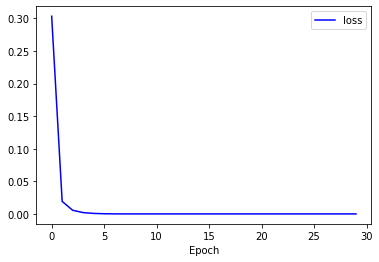

In [ ]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# test_x_array 각 샘플의 2시간 예측값이 기록되어 있는 test_pred_array shape 확인
print(test_pred_array.shape)

(529, 120, 1)


In [ ]:
# 모델 저장 및 로드
model.save('./my_model.h5')
model = tf.keras.models.load_model('./my_model.h5')

In [ ]:
# 매수 시점, 매수 비율 표 만들기
# 1) train_pred_array 3차원에서 2차원으로 바꾸기
pred_array_2d = np.zeros([test_pred_array.shape[0], 120])

for idx in tqdm(range(test_pred_array.shape[0])):
    pred_array_2d[idx, :] = test_pred_array[idx, :, 0]

# 2) 예측값을 재해석하여 submission 표를 작성하는 함수 정의
def array_to_submission(pred_array):
    submission = pd.DataFrame(np.zeros([pred_array.shape[0], 2], np.int64),
                              columns=['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    sell_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis=1)):
        sell_price.append(pred_array[idx, sell_time])
    sell_price = np.array(sell_price)
    submission.loc[:, 'buy_quantity'] = ((1*1*(sell_price/1)*0.9995*0.9995) > 1.08)*1 #-DACON-Bit_Trader폴더 주가 손실계산.png 참고
    submission['sell_time'] = np.argmax(pred_array, axis=1)
    submission.columns = ['sample_id', 'buy_quantity', 'sell_time']
    return submission, sell_price

final_submission, forecasted_max = array_to_submission(pred_array_2d)

100%|██████████| 529/529 [00:00<00:00, 190355.77it/s]


In [ ]:
# final_submission csv파일로 저장
final_submission.to_csv('./submission.csv', index = False)

In [ ]:
# 각 샘플의 예측치 중 최고값 모아 보기
forecasted_max

array([0.99719197, 1.00981784, 1.01140642, 0.99340111, 0.99319822,
       1.0270983 , 0.97917253, 0.98605061, 0.99617916, 0.99335527,
       1.02530491, 0.98365331, 1.00783813, 0.99297178, 0.99900377,
       1.01193273, 1.01209295, 1.00485599, 1.02772915, 1.00596106,
       1.01499665, 0.9953807 , 1.01058614, 1.03651869, 1.01820469,
       1.04948843, 1.05893981, 0.99145478, 0.99275988, 0.99086547,
       1.00092685, 1.01278436, 1.03628635, 0.9885366 , 1.00358939,
       1.03088057, 0.9865995 , 0.98372841, 1.00465035, 1.02363682,
       0.96776193, 0.99441922, 1.00089777, 1.02136457, 0.95815814,
       1.00686109, 1.00094032, 1.00206649, 0.99357307, 1.02814078,
       1.02205753, 0.99247354, 1.00590479, 0.99537724, 0.99566615,
       0.98450869, 0.99282688, 0.99856609, 1.01761413, 1.00137353,
       1.06282401, 0.99763858, 1.01748478, 0.97290933, 1.01792824,
       0.99591929, 0.98458332, 1.00015402, 1.05327845, 0.99301493,
       1.00874877, 1.01287889, 1.03300166, 0.95324552, 0.99688

In [ ]:
# 전체 300가지 sample에 대해 _가지 case에서 (수수료 감안해서) 매수 시점(1380분)보다 108% 이상 상승한다고 예측함.
final_submission.buy_quantity.value_counts()

0    527
1      2
Name: buy_quantity, dtype: int64

In [ ]:
# (수수료 감안하지 않고) 매수 시점보다 108% 이상 상승한다고 예측한 경우, 해당 예측치들 모아 보기
forecasted_max[forecasted_max >= 1.08]

array([1.08022141, 1.08999872, 1.09125054])

---

In [ ]:
# 모델 평가: test_x데이터로 예측하는 방식을 입력값(train_x)에 대한 예측값과 실제값(train_y_array) 비교를 통해 평가

train_pred_array = np.zeros([1, 120, 1])

sample = 100  #평가용 임의의 샘플 id

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10, mode = 'auto')
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience= 3, min_lr = 0)

ep = 30
bs = 120
# train_x_array데이터로 시계열 Windows 만들기
# idx에 해당하는 샘플 하나만 학습하므로 for loop는 한 번만 돌아감
for idx in range(sample, sample+1):
    seq_len = 120  # window_size와 같은 개념
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(train_x_array[idx, :, 1][index: index + sequence_length])

    # x_train, y_train 데이터 구성
    windows = np.array(windows) #1329 * 121의 2차원 배열
    x_train = windows[:, :-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_train = windows[:, -1]

    
    # Fit(early_stoppage & reduceLR 적용)
    model = build_model()
    history = model.fit(x_train, y_train, validation_split=0.1, epochs = ep, batch_size = bs, verbose = 2, callbacks = [early_stop, reduceLR])
    print('sample_id : ', idx, '번')
    print('loss : ', history.history['loss'][-1])
#     print('mse : ', history.history['mse'][-1])  #<- model.compile()의 metrics인자값으로 설정된 값을 추가로 출력해 주고 싶다면!
    print('lr : ', round(model.optimizer.lr.numpy(), 5))  #<-조정된 학습률 출력

    # train_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]
    window_3d = np.reshape(window, (1, window.shape[0], 1))
    for m in range(120):
        # model.predict()에 window_3d 넣어 예측
        pred = model.predict(window_3d)

        # 120분 중 처음 1분 예측값 train_pred_array에 기록
        train_pred_array[:, m, :] = pred

        # window_3d의 첫번째 분 값은 삭제한 window_3d_2nd 구성
        window_3d_2nd = window_3d[0, 1:, :]  # 119개

        # pred_target(prediction할 때마다 나오는 각각의 예측값들) 1차원 -> 2차원으로 구성
        pred_target = train_pred_array[:, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))

        # train_pred_array와 window_3d_2nd 병합하여 모델에 입력할 새로운 window_3d 재구성
        # 이렇게 predict매서드에 들어갈 수 있는 형태로 만들어 줌으로써 얻은 이점: 1. Loop 돌리는 것 가능, 2. window가 이동하여 test_x의 마지막 윈도우의 값이 더 이상 남아 있지 않아도, 예상값들로만 새롭게 window를 구성하여 입력하는 방식으로 구현할 수 있게 해줌. 
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))

Epoch 1/30
10/10 - 4s - loss: 0.2075 - mse: 0.2075 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 2/30
10/10 - 0s - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 3/30
10/10 - 0s - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 4/30
10/10 - 0s - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 5/30
10/10 - 0s - loss: 7.1156e-04 - mse: 7.1156e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 6/30
10/10 - 0s - loss: 3.1400e-04 - mse: 3.1400e-04 - val_loss: 9.1364e-05 - val_mse: 9.1364e-05
Epoch 7/30
10/10 - 0s - loss: 1.3843e-04 - mse: 1.3843e-04 - val_loss: 3.1319e-04 - val_mse: 3.1319e-04
Epoch 8/30
10/10 - 0s - loss: 7.5068e-05 - mse: 7.5068e-05 - val_loss: 1.6353e-05 - val_mse: 1.6353e-05
Epoch 9/30
10/10 - 0s - loss: 5.2147e-05 - mse: 5.2147e-05 - val_loss: 1.1659e-04 - val_mse: 1.1659e-04
Epoch 10/30
10/10 - 0s - loss: 4.4714e-05 - mse: 4.4714e-05 - val_loss: 8.5753e-05 - val_mse: 8.5753e-05
Epoch 11/30
10/10 - 0s - loss: 

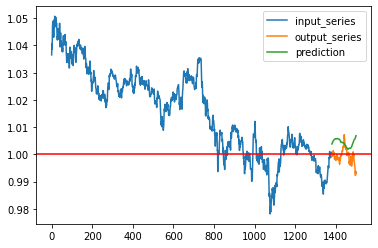

In [ ]:
# train 샘플 훈련 성과 시각화해보기
# 1) 입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 정의
def plot_series(x_series, y_series):
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

# 2) train data 중 sample_id idx에 해당하는 x_series로 모델을 학습한 후 y_series를 추론
x_series = train_x_array[sample,:,1]
y_series = train_y_array[sample,:,1]
plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), train_pred_array[0,:,0], label = 'prediction')
plt.legend()
plt.show()

In [ ]:
train_pred_array

array([[[1.00380278],
        [1.00395   ],
        [1.00414443],
        [1.00431597],
        [1.00449693],
        [1.00466335],
        [1.00478911],
        [1.00495148],
        [1.005059  ],
        [1.00514889],
        [1.00526905],
        [1.00539577],
        [1.00548232],
        [1.00554085],
        [1.00558197],
        [1.00560498],
        [1.00564885],
        [1.00568712],
        [1.00571704],
        [1.00575328],
        [1.00576079],
        [1.00568628],
        [1.00566626],
        [1.00566697],
        [1.00572729],
        [1.0057708 ],
        [1.00576448],
        [1.00575471],
        [1.00574076],
        [1.00572741],
        [1.00567985],
        [1.00564265],
        [1.00566304],
        [1.00568032],
        [1.00567269],
        [1.0055995 ],
        [1.00547457],
        [1.00542176],
        [1.00537515],
        [1.00531459],
        [1.00522852],
        [1.00508106],
        [1.00489306],
        [1.00470483],
        [1.00448513],
        [1

In [ ]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index

def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

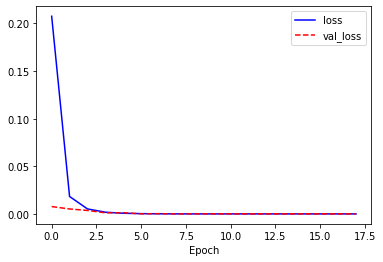

In [ ]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
total_momey, total_momey_list = COIN(train_y_df,
                                     train_pred_array)
print(total_momey)

AttributeError: ignored

---

In [ ]:
# train_x_df의 자료들을 학습에 활용하게 될 경우:
# train_x_df를 sample_id을 기준으로 추출하는 방법
train_x_df = train_x_df[train_x_df.sample_id < 300]
train_y_df = train_y_df[train_y_df.sample_id < 300]